In [1]:
%%shell
# Inspred by https://colab.research.google.com/github/tensorflow/io/blob/master/docs/tutorials/postgresql.ipynb#scrollTo=YUj0878jPyz7
sudo apt-get -y -qq update
sudo apt-get -y -qq install postgresql-14
# Start postgresql server
sudo sed -i "s/port = 5432/port = 5433/g" /etc/postgresql/14/main/postgresql.conf
sudo service postgresql start
# Set password
sudo -u postgres psql -U postgres -c "ALTER USER postgres PASSWORD 'pyqrlew-db'"
# Install python packages
pip install -U pyqrlew graphviz

UsageError: Cell magic `%%shell` not found.


In [2]:
from pyqrlew.io import PostgreSQL
# Read data
db = PostgreSQL()
dataset = db.retail()

Error response from daemon: network with name qrlew-net already exists


In [3]:
dataset.relations()

[(['retail.features'], <Relation at 0x11528cd80>),
 (['retail.sales'], <Relation at 0x11528cf90>),
 (['retail.stores'], <Relation at 0x11528cf00>)]

# Utils

In [4]:
from IPython.display import display
import graphviz

def display_dot(dot_graph): 
    # graph = graphviz.Source(dot_graph)

    # # # Set the size of the graph
    # # graph.graph_attr['size'] = '8,6'  # Adjust the width and height as needed

    # # # Render the graph to a PNG image
    # # graph.format = 'png'
    # graph.render(filename='graph', format='png', cleanup=True)

    # # Display the graph image with a specific size
    # display(Image(filename='graph.png', width=1600))
    display(graphviz.Source(dot_graph))

In [5]:
MAGENTA_COLOR = '\033[35m'  
BLUE_COLOR = '\033[34m'
RESET_COLOR = '\033[0m'    

def print_query(query: str):
    keywords = ["SELECT", "AS", "GROUP BY", "LIMIT", "ORDER BY", "WHERE"]
    colored_query = query
    colored_query = colored_query.replace("WITH", "WITH\n ")
    colored_query = colored_query.replace(" SELECT", "\nSELECT")
    colored_query = colored_query.replace("),", "),\n ") 
    for word in keywords:
        colored_query = colored_query.replace(word, MAGENTA_COLOR + word + RESET_COLOR)
    colored_query = colored_query.replace("WITH", BLUE_COLOR + "WITH" + RESET_COLOR)
    print(colored_query)

print_query("WITH customers AS (SELECT * FROM table) SELECT * FROM customers WHERE age > 25")

WITH
  customers AS (SELECT * FROM table)
SELECT * FROM customers WHERE age > 25


In [6]:
import json
from termcolor import colored

def to_json(str_schema: str):
    str_schema_to_json = str_schema.replace(" ", "")
    str_schema_to_json = str_schema_to_json.replace("{", '{"')
    str_schema_to_json = str_schema_to_json.replace(":", '":"')
    str_schema_to_json = str_schema_to_json.replace(",", '","')
    str_schema_to_json = str_schema_to_json.replace("}", '"}')
    return json.loads(str_schema_to_json)

def print_colored_json(json_data):
    formatted_json = json.dumps(json_data, indent=4)
    colored_json = highlight_keywords(formatted_json)
    print(colored_json)

def highlight_keywords(json_string):
    keywords = {
        "_PROTECTED_ENTITY_ID_": "red", 
        "_PROTECTED_ENTITY_WEIGHT_": "red", 
        "option": "yellow",
        "float": "blue", 
        "int": "blue"
    }
    for keyword, color in keywords.items():
        json_string = json_string.replace(keyword, colored(keyword, color))
    return json_string

str_schema = '{_PROTECTED_ENTITY_ID_: option(str), _PROTECTED_ENTITY_WEIGHT_: int[0 1469283], field_l_2l: float[0 2468395440]}'

print_colored_json(str_schema)


"{_PROTECTED_ENTITY_ID_: option(str), _PROTECTED_ENTITY_WEIGHT_: int[0 1469283], field_l_2l: float[0 2468395440]}"


In [7]:
import pandas as pd
pd.DataFrame(db.sql("SELECT * FROM retail.features LIMIT 5"))

,id,store,date,temperature,fuel_price,cpi,unemployment,isholiday
0,1,1,2010-02-05,42.31,2.572,211.096358,8.106,False
1,2,1,2010-02-12,38.51,2.548,211.242170,8.106,True
2,3,1,2010-02-19,39.93,2.514,211.289143,8.106,False
3,4,1,2010-02-26,46.63,2.561,211.319643,8.106,False
4,5,1,2010-03-05,46.50,2.625,211.350143,8.106,False


In [8]:
import matplotlib.pyplot as plt

def plot_hist(true_value, data, query):
    plt.axvline(true_value, color='red', label="True")
    for e, d in data.items():
        plt.hist(d, bins=10, alpha=0.5, label = f"eps = {e}")
    plt.legend()
    plt.title(query)

In [9]:
N_RUNS = 100

def run(dataset, query, epsilons):
    data = {}
    str_pe = """
    {
    "protected_entity": [
        ["stores", [["store", "features", "store"]], "id"],
        ["features", [], "id"],
        ["sales", [], "id"]
    ]
    }
    """
    delta  = 1e-1
    relation = dataset.sql(query)
    for epsilon in epsilons: 
        dp_relation = relation.dp_compilation(
            dataset,
            str_pe,
            epsilon, 
            delta
        )
        dp_query = dp_relation.render()
        data[epsilon] = [
            execute_query(dp_query)["my_sum"][0] for _ in range(N_RUNS)
        ]
    return data

# Read Data

For this demo, we use the retail dataset containing 3 tables: 
 - features
 - sales
 - stores

We create a `Dataset` object from json files describing the tables and the columns (type, min, max, possible values .. ) of the dataset.

All the tables have been converted into `Relation` object: 

In [10]:
dataset.relations()

[(['retail.features'], <Relation at 0x1247198d0>),
 (['retail.sales'], <Relation at 0x1247197e0>),
 (['retail.stores'], <Relation at 0x1247196c0>)]

The corresponding `Relation` is given by: 

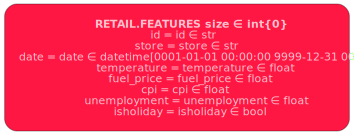

In [11]:
display_dot(dataset.relations()[0][1].dot())

A `Relation` contains information about the data types of each columns.

# Create a relation from an SQL query

We can create a `Relation` from a `Dataset` and an SQL query: 

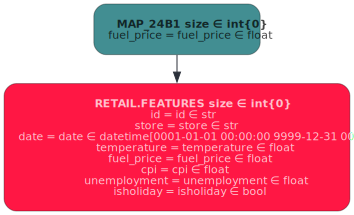

In [12]:
relation = dataset.sql('SELECT fuel_price As fuel_price FROM "retail.features"')
display_dot(relation.dot())

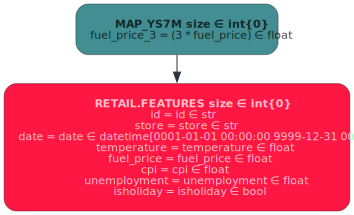

In [13]:
relation = dataset.sql('SELECT 3 * fuel_price AS fuel_price_3 FROM "retail.features"')
display_dot(relation.dot())

The data types have been propagated without any query to the database. 


We can try with an aggregation: 

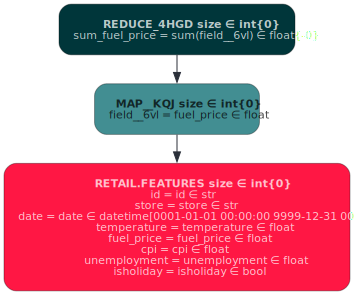

In [14]:
query = 'SELECT SUM(fuel_price) As sum_fuel_price FROM "retail.features"'
relation = dataset.sql(query)
display_dot(relation.dot())

Convert the `Relation` to an SQL query: 

In [15]:
#SELECT SUM(fuel_price) As sum_fuel_price FROM features
print_query(relation.render())

WITH
  map__kqj (field__6vl) AS (SELECT fuel_price AS field__6vl FROM retail.features),
  reduce_4hgd (sum_fuel_price) AS (SELECT sum(field__6vl) AS sum_fuel_price FROM map__kqj)
SELECT * FROM reduce_4hgd


We send this query to the DB: 

In [18]:
res = db.eval(relation)
pd.DataFrame(res)

,sum_fuel_price
0,2965.117


Which gives the same results than the initial query: 

In [19]:
true_res = db.sql(query.replace('"', ''))
pd.DataFrame(true_res)

,sum_fuel_price
0,2965.117


# Protection

In [20]:
query

'SELECT SUM(fuel_price) As sum_fuel_price FROM "retail.features"'

The `protect` method transforms the initial `Relation` into a `Relation` where the protected entities are preserved, i.e. each row is owned by ony one individual. 

It inputs: 
- a `Dataset`
- a json string that contains the protected entity of each table:

In [21]:
str_pe = """
{
  "protected_entity": [
    ["retail.stores", [["store", "retail.features", "store"]], "id"], 
    ["retail.features", [], "id"], 
    ["retail.sales", [], "id"]
  ]
}
"""

The protected entity of `features` is its column `id`:

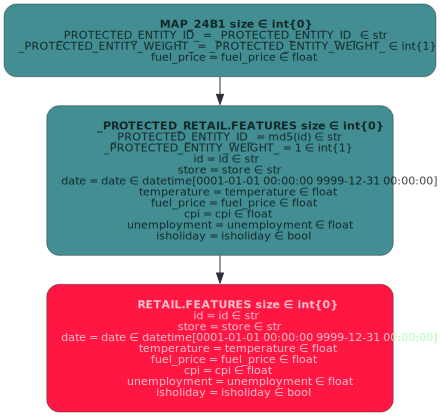

In [22]:
_relation = dataset.sql('SELECT fuel_price FROM "retail.features"')
_protected_relation = _relation.protect(
    dataset,
    str_pe
)
display_dot(_protected_relation.dot())

The protected entity of `stores` is the `id` column of `features`:

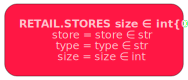

In [23]:
display_dot(dataset.relations()[2][1].dot())

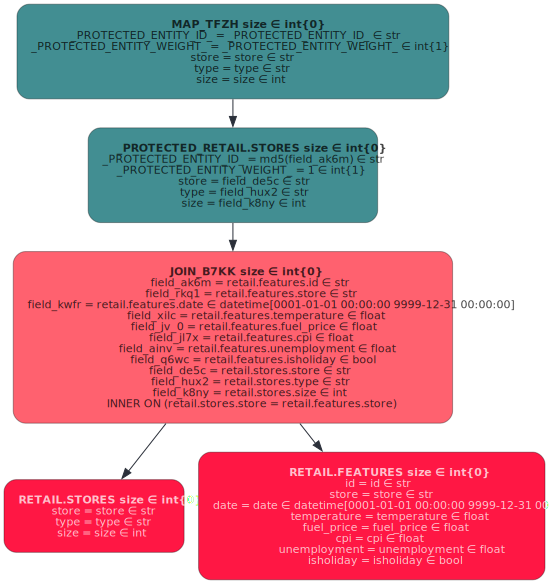

In [24]:
#protected entity: ["retail.stores", [["store", "retail.features", "store"]], "id"]
_relation = dataset.sql('SELECT * FROM "retail.stores"')
_protected_relation = _relation.protect(
    dataset,
    str_pe
)
display_dot(_protected_relation.dot())

We apply `protect`  to the `Relation` build from `SELECT SUM(fuel_price) As sum_fuel_price FROM features`:

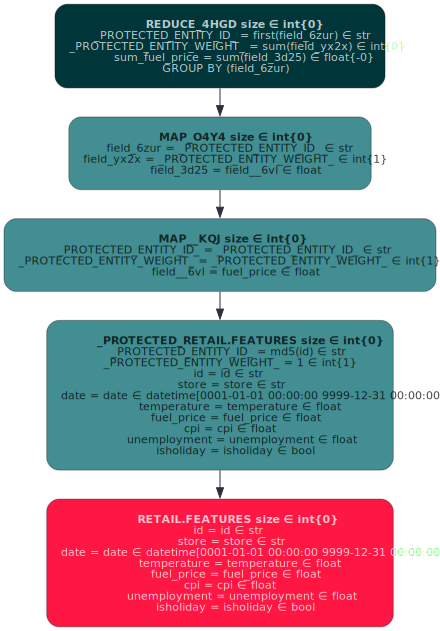

In [25]:
protected_relation = relation.protect(
    dataset,
    str_pe
)
display_dot(protected_relation.dot())

The protection reorganises the inital `Relation` so that the output `Relation` preserves the protected entity : **in the protected `Relation`, we are sure than each row is owned by only one individual.**

In our example, the initial `SUM` over the entire dataset has been replaced by a `SUM` groupped by the protected entities. 

In [26]:
print_colored_json(protected_relation.schema())

"{_PROTECTED_ENTITY_ID_: str, _PROTECTED_ENTITY_WEIGHT_: int{0}, sum_fuel_price: float{-0}}"


In [27]:
print_query(protected_relation.render())

WITH
  _protected_retail.features (_PROTECTED_ENTITY_ID_, _PROTECTED_ENTITY_WEIGHT_, id, store, date, temperature, fuel_price, cpi, unemployment, isholiday) AS (SELECT md5(id) AS _PROTECTED_ENTITY_ID_, 1 AS _PROTECTED_ENTITY_WEIGHT_, id AS id, store AS store, date AS date, temperature AS temperature, fuel_price AS fuel_price, cpi AS cpi, unemployment AS unemployment, isholiday AS isholiday FROM retail.features),
  map__kqj (_PROTECTED_ENTITY_ID_, _PROTECTED_ENTITY_WEIGHT_, field__6vl) AS (SELECT _PROTECTED_ENTITY_ID_ AS _PROTECTED_ENTITY_ID_, _PROTECTED_ENTITY_WEIGHT_ AS _PROTECTED_ENTITY_WEIGHT_, fuel_price AS field__6vl FROM _protected_retail.features),
  map_o4y4 (field_6zur, field_yx2x, field_3d25) AS (SELECT _PROTECTED_ENTITY_ID_ AS field_6zur, _PROTECTED_ENTITY_WEIGHT_ AS field_yx2x, field__6vl AS field_3d25 FROM map__kqj),
  reduce_4hgd (_PROTECTED_ENTITY_ID_, _PROTECTED_ENTITY_WEIGHT_, sum_fuel_price) AS (SELECT field_6zur AS _PROTECTED_ENTITY_ID_, sum(field_yx2x) AS _PROTECTED

In [29]:
pd.DataFrame(db.sql("SELECT * FROM retail.features"))

,id,store,date,temperature,fuel_price,cpi,unemployment,isholiday
0,1,1,2010-02-05,42.31,2.572,211.096358,8.106,False
1,2,1,2010-02-12,38.51,2.548,211.242170,8.106,True
2,3,1,2010-02-19,39.93,2.514,211.289143,8.106,False
3,4,1,2010-02-26,46.63,2.561,211.319643,8.106,False
4,5,1,2010-03-05,46.50,2.625,211.350143,8.106,False
...,...,...,...,...,...,...,...,...
905,906,5,2013-06-28,86.09,3.495,NaN,NaN,False
906,907,5,2013-07-05,82.06,3.422,NaN,NaN,False
907,908,5,2013-07-12,85.75,3.400,NaN,NaN,False
908,909,5,2013-07-19,79.73,3.556,NaN,NaN,False


In [ ]:
db.eval(protected_relation) # does not work

In [ ]:
db.eval(protected_relation)

We have one sum per protected entity. If we sum all the rows, we find the same results than with the initial query: 

In [30]:
#SELECT SUM(fuel_price) As sum_fuel_price FROM features
true_res = db.query(query)
summed_res = db.eval(relation.render()).sum()

print(f"Initial query:                       sum_fuel_price: {true_res.iloc[0][0]}")
print(f"Sum over the all protected entities: sum_fuel_price: {summed_res[0]}")

AttributeError: 'PostgreSQL' object has no attribute 'query'

# Dp compilation

With the `dp_compilation` method, we transform a query into its differentially private equivalent. 

It inputs: 
- the privacy parameters `epsilon` and `delta`
- a json string containing the protected entities of each table
- a `Dataset`
- an SQL query

In [ ]:
str_pe = """
{
  "protected_entity": [
    ["stores", [["store", "features", "store"]], "id"], 
    ["features", [], "id"],
    ["sales", [], "id"]
  ]
}
"""
epsilon = 1. 
delta  = 1e-3
relation = dataset.query("SELECT SUM(fuel_price) AS my_sum FROM retail.features")
dp_relation = relation.dp_compilation(
    dataset,
    str_pe,
    epsilon, 
    delta
)

In [ ]:
display(graphviz.Source(dp_relation.dot()))

In [ ]:
print_query(protected_relation.render())

In [ ]:
true_res = db.query(query)
res = db.eval(dp_relation)

print(f"Initial query:                         SUM(fuel_price): {true_res.iloc[0][0]}")
print("Sum over the all protected entities:   SUM(fuel_price): ", res["my_sum"][0])

In [ ]:
true_value = true_res.iloc[0][0]
query = "SELECT SUM(fuel_price) AS my_sum FROM features"
data = run(dataset, query, [0.1, 1., 2.])

In [ ]:
plot_hist(true_value, data, query)